In [1]:
# === Cell 1: Setup & Mount Drive ===
from google.colab import drive
drive.mount('/content/drive')

!pip install --upgrade pip
!pip install ultralytics opencv-python matplotlib seaborn albumentations
!pip install gdown


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [ultralytics]


In [2]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.4 MB/s eta 0:00:00


In [3]:
import gdown
import zipfile

# File ID extracted from your link
file_id = "1zOvorLRxaxEJxqY8YyMmP3KI1nPXX70Z"
url = f"https://drive.google.com/uc?id={file_id}"
output = "falcon_dataset.zip"

# Download from Google Drive
gdown.download(url, output, quiet=False)

# Unzip dataset
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("falcon_dataset")

!ls falcon_dataset


Downloading...
From (original): https://drive.google.com/uc?id=1zOvorLRxaxEJxqY8YyMmP3KI1nPXX70Z
From (redirected): https://drive.google.com/uc?id=1zOvorLRxaxEJxqY8YyMmP3KI1nPXX70Z&confirm=t&uuid=93bfa452-eb5b-4dd5-97ed-d231a5b685ab
To: /content/falcon_dataset.zip
100%|██████████| 6.30G/6.30G [00:38<00:00, 165MB/s]


train_3


In [4]:
# === Cell 3: Prepare YOLO Dataset YAML Config ===
# Adjust paths according to your unzipped folder structure

dataset_yaml = """
train: falcon_dataset/train/images
val:   falcon_dataset/val/images
test:  falcon_dataset/test/images

nc: 7
names: [\"Oxygen Tank\", \"Nitrogen Tank\", \"First Aid Box\", \"Fire Alarm\", \"Safety Switch Panel\", \"Emergency Phone\", \"Fire Extinguisher\"]
"""

with open("falcon.yaml", "w") as f:
    f.write(dataset_yaml)

!cat falcon.yaml



train: falcon_dataset/train/images
val:   falcon_dataset/val/images
test:  falcon_dataset/test/images

nc: 7
names: ["Oxygen Tank", "Nitrogen Tank", "First Aid Box", "Fire Alarm", "Safety Switch Panel", "Emergency Phone", "Fire Extinguisher"]


Training images found in: falcon_dataset/train_3/train3/images
176 images moved to validation folder: falcon_dataset/val/images


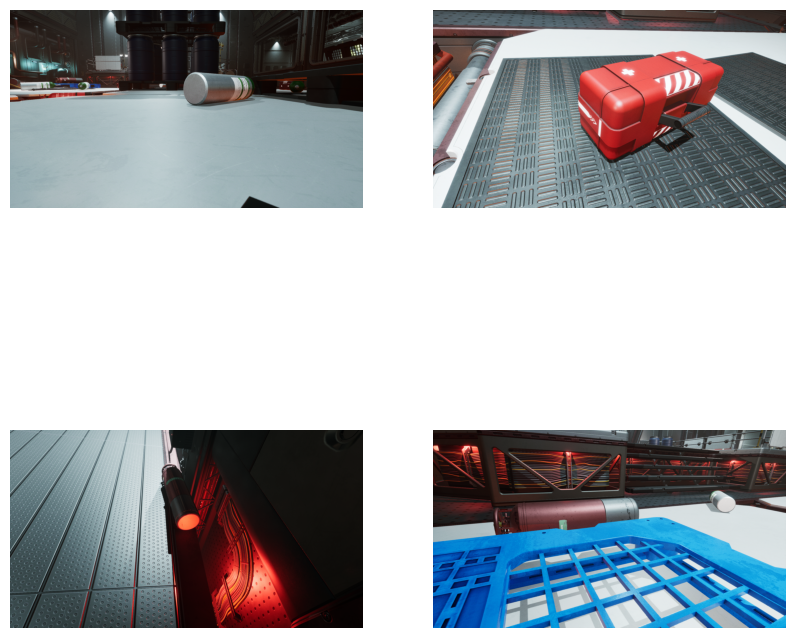

In [5]:
# === Cell 4: Prepare Dataset and Validation Folder ===
import os
import random
import shutil
import cv2
import matplotlib.pyplot as plt

# Function to find the first folder with images
def find_images_folder(base_dir="falcon_dataset"):
    for root, dirs, files in os.walk(base_dir):
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                return root
    return None

# Auto-detect train images folder
train_img_dir = find_images_folder("falcon_dataset")
if not train_img_dir:
    raise FileNotFoundError("No images folder found inside 'falcon_dataset'. Check the zip extraction.")

print(f"Training images found in: {train_img_dir}")

# --- Create validation folder by taking 10% of train images ---
val_img_dir = "falcon_dataset/val/images"
os.makedirs(val_img_dir, exist_ok=True)

train_images = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
val_samples = random.sample(train_images, max(1, len(train_images)//10))

for img in val_samples:
    shutil.move(os.path.join(train_img_dir, img), os.path.join(val_img_dir, img))

print(f"{len(val_samples)} images moved to validation folder: {val_img_dir}")

# --- Function to show random examples ---
def show_random_examples(img_dir, n=4):
    imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    if len(imgs) == 0:
        raise FileNotFoundError(f"No images found in '{img_dir}'.")

    samples = random.sample(imgs, min(n, len(imgs)))
    plt.figure(figsize=(10,10))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2,2,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Show 4 random train images
show_random_examples(train_img_dir, n=4)


In [6]:
# === Cell 5: Fast & Safe Training Mode ===
import yaml
import random
import shutil
import os
from ultralytics import YOLO

# --- Create falcon.yaml dynamically (if not already created) ---
dataset_yaml = {
    "train": train_img_dir,
    "val": val_img_dir,
    "test": val_img_dir,  # validation as test for simplicity
    "nc": 7,
    "names": ["Oxygen Tank", "Nitrogen Tank", "First Aid Box",
              "Fire Alarm", "Safety Switch Panel", "Emergency Phone",
              "Fire Extinguisher"]
}

with open("falcon_fast.yaml", "w") as f:
    yaml.dump(dataset_yaml, f)

print("falcon_fast.yaml created:")
!cat falcon_fast.yaml

# --- Optional: Use a small subset of train images for fast testing ---
fast_train_dir = "falcon_dataset/train_fast/images"
os.makedirs(fast_train_dir, exist_ok=True)

# Copy 20 images max for fast training
train_images = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
subset_images = random.sample(train_images, min(20, len(train_images)))

for img in subset_images:
    shutil.copy(os.path.join(train_img_dir, img), os.path.join(fast_train_dir, img))

# Update YAML to use fast_train_dir
dataset_yaml["train"] = fast_train_dir
with open("falcon_fast.yaml", "w") as f:
    yaml.dump(dataset_yaml, f)

# --- Train YOLOv8 in fast mode ---
model = YOLO("yolov8n.pt")  # lightweight nano model

model.train(
    data="falcon_fast.yaml",
    epochs=3,          # very few epochs for fast testing
    imgsz=320,         # smaller image size for speed
    batch=4,           # smaller batch for Colab GPU
    project="runs_fast",
    name="exp_falcon_fast",
    save=True          # saves checkpoints
)

print("Fast training complete. Check runs_fast/exp_falcon_fast for outputs.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
falcon_fast.yaml created:
names:
- Oxygen Tank
- Nitrogen Tank
- First Aid Box
- Fire Alarm
- Safety Switch Panel
- Emergency Phone
- Fire Extinguisher
nc: 7
test: falcon_dataset/val/images
train: falcon_dataset/train_3/train3/images
val: falcon_dataset/val/images
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=falcon_fast.yaml, degrees=0.0, deterministic=True, device=None, dfl=1

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        2/3     0.232G          0       7.78          0          0        320: 100% ━━━━━━━━━━━━ 5/5 5.3it/s 1.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 3.4it/s 6.4s
                   all        176          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        3/3     0.248G          0      7.729          0          0        320: 100% ━━━━━━━━━━━━ 5/5 6.6it/s 0.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 2.8it/s 8.0s
                   all        176          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



3 epochs completed in 0.007 hours.
Optimizer stripped from /content/runs_fast/exp_falcon_fast/weights/last.pt, 6.2MB
Optimizer stripped from /content/runs_fast/exp_falcon_fast/weights/best.pt, 6.2MB

Validating /content/runs_fast/exp_falcon_fast/weights/best.pt...
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 2.8it/s 7.7s


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:668: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/ultraly

                   all        176          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 0.1ms preprocess, 3.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to /content/runs_fast/exp_falcon_fast
Fast training complete. Check runs_fast/exp_falcon_fast for outputs.


In [ ]:
# === Cell 5: Train YOLOv8 Model on Full Dataset ===
from ultralytics import YOLO

# Load a lightweight YOLOv8 model to start (yolov8n, yolov8s, etc.)
model = YOLO("yolov8n.pt")

# Train on the full dataset
model.train(
    data="falcon.yaml",   # Dataset config
    epochs=50,            # Full training
    imgsz=640,
    batch=16,
    project="runs",       # Folder to save results
    name="exp_falcon",    # Experiment name
    save=True             # Ensure best.pt is saved
)


In [7]:
# === Cell 6: Evaluate Model Performance ===
metrics = model.val()  # runs evaluation on validation set
print(metrics)


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4077.7±1048.0 MB/s, size: 2694.8 KB)
val: Scanning /content/falcon_dataset/val/labels.cache... 0 images, 176 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 176/176 343.8Kit/s 0.0s
WARNING ⚠️ Labels are missing or empty in /content/falcon_dataset/val/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 44/44 5.7it/s 7.7s


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:668: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/ultraly

                   all        176          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 0.1ms preprocess, 5.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /content/runs_fast/exp_falcon_fast2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([], dtype=int64)
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ac6bcbb28a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,   

In [9]:
# === Cell 7: Robust Inference / Prediction Script ===
import os
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

# --- Detect existing image folder ---
possible_folders = [
    "falcon_dataset/test/images",
    "falcon_dataset/val/images",
    "falcon_dataset/train/images"
]

source_folder = None
for folder in possible_folders:
    if os.path.exists(folder) and len(os.listdir(folder)) > 0:
        source_folder = folder
        break

if source_folder is None:
    raise FileNotFoundError("No images found for inference. Add images to test/val/train folders.")

print(f"Running predictions on: {source_folder}")

# --- Create output folder ---
out_dir = os.path.join("runs", "exp_falcon_preds", "images")
os.makedirs(out_dir, exist_ok=True)

# --- Run YOLOv8 predictions ---
results = model.predict(
    source=source_folder,
    save=True,
    project="runs",
    name="exp_falcon_preds"
)

# --- Display first 4 predicted images ---
pred_imgs = os.listdir(os.path.join("runs", "exp_falcon_preds", "images"))
for img_name in pred_imgs[:4]:
    img_path = os.path.join("runs", "exp_falcon_preds", "images", img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


Running predictions on: falcon_dataset/val/images

image 1/176 /content/falcon_dataset/val/images/000000010_light_cluttered_room.png: 192x320 (no detections), 39.3ms
image 2/176 /content/falcon_dataset/val/images/000000012_light_uncluttered.png: 192x320 (no detections), 7.0ms
image 3/176 /content/falcon_dataset/val/images/000000022_light_cluttered.png: 192x320 (no detections), 6.0ms
image 4/176 /content/falcon_dataset/val/images/000000024_light_cluttered.png: 192x320 (no detections), 6.4ms
image 5/176 /content/falcon_dataset/val/images/000000028_light_uncluttered.png: 192x320 (no detections), 10.5ms
image 6/176 /content/falcon_dataset/val/images/000000030_light_uncluttered.png: 192x320 (no detections), 6.1ms
image 7/176 /content/falcon_dataset/val/images/000000033_light_cluttered.png: 192x320 (no detections), 6.4ms
image 8/176 /content/falcon_dataset/val/images/000000034_light_cluttered_room.png: 192x320 (no detections), 5.9ms
image 9/176 /content/falcon_dataset/val/images/000000036_cl

In [10]:
# === Cell 8: Export train.py and predict.py Scripts ===
# train.py
train_py = """
from ultralytics import YOLO

if __name__ == '__main__':
    model = YOLO("yolov8n.pt")
    model.train(
        data="falcon.yaml",
        epochs=50,
        imgsz=640,
        batch=16,
        project="runs",
        name="exp_falcon"
    )
"""

with open("train.py", "w") as f:
    f.write(train_py)

# predict.py
predict_py = """
from ultralytics import YOLO

if __name__ == '__main__':
    model = YOLO("runs/exp_falcon/weights/best.pt")
    _ = model.predict(
        source="falcon_dataset/test/images",
        save=True,
        project="runs",
        name="exp_falcon_preds"
    )
"""

with open("predict.py", "w") as f:
    f.write(predict_py)

!ls -lh train.py predict.py


-rw-r--r-- 1 root root 259 Oct  4 14:29 predict.py
-rw-r--r-- 1 root root 246 Oct  4 14:29 train.py


In [11]:
# === Cell 9: Package Final Submission Folder ===
import shutil

submission_folder = "Final_Submission"
if os.path.exists(submission_folder):
    shutil.rmtree(submission_folder)

os.makedirs(submission_folder)
# Copy scripts
shutil.copy("train.py", submission_folder)
shutil.copy("predict.py", submission_folder)
# Copy config
shutil.copy("falcon.yaml", submission_folder)
# Copy runs directory (logs, outputs)
shutil.copytree("runs", os.path.join(submission_folder, "runs"))
# Zip it
shutil.make_archive("Final_Submission", 'zip', submission_folder)

!ls -lh Final_Submission.zip


-rw-r--r-- 1 root root 99M Oct  4 14:30 Final_Submission.zip
